In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import shap
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
binary_encoder = LabelEncoder()
for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0, 'Female': 1, 'Male': 0})
df = pd.get_dummies(df, drop_first=True)

In [4]:
x = df.drop('Churn', axis =1)
y = df['Churn']

In [5]:
scaler = StandardScaler()
x_scaled = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)
y = y.astype(int) 

In [6]:
sm = SMOTE(random_state=42)
x_res, y_res = sm.fit_resample(x_scaled, y)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x_res, y_res, test_size=0.2, random_state=42)

In [8]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
rf = RandomForestClassifier(random_state=42)
grid = GridSearchCV(rf, param_grid, cv=3, scoring='roc_auc')
grid.fit(x_train, y_train)
best_model = grid.best_estimator_

In [9]:
y_pred = best_model.predict(x_test)
y_proba = best_model.predict_proba(x_test)[:, 1]
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
print("Classification Reprt: \n", classification_report(y_test, y_pred))
print("ROC AUC Score: \n", roc_auc_score(y_test, y_proba))

Confusion Matrix: 
 [[958  63]
 [207 842]]
Classification Reprt: 
               precision    recall  f1-score   support

           0       0.82      0.94      0.88      1021
           1       0.93      0.80      0.86      1049

    accuracy                           0.87      2070
   macro avg       0.88      0.87      0.87      2070
weighted avg       0.88      0.87      0.87      2070

ROC AUC Score: 
 0.9495261099372659


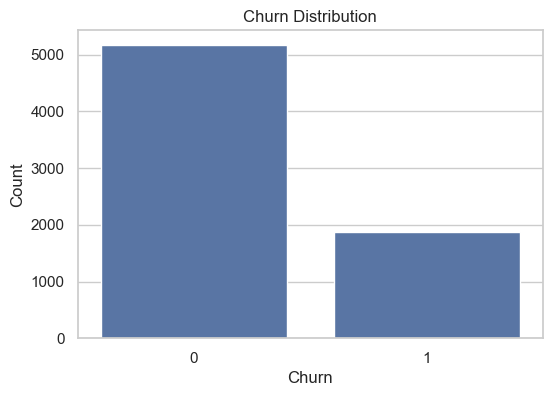

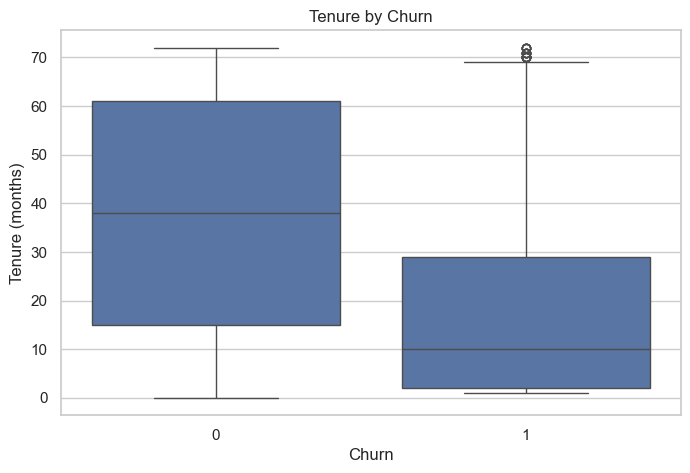

In [10]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# ----- 1. Churn Distribution -----
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()

# ----- 2. Box Plot: Tenure vs Churn -----
plt.figure(figsize=(8, 5))
sns.boxplot(x='Churn', y='tenure', data=df)
plt.title('Tenure by Churn')
plt.xlabel('Churn')
plt.ylabel('Tenure (months)')
plt.show()

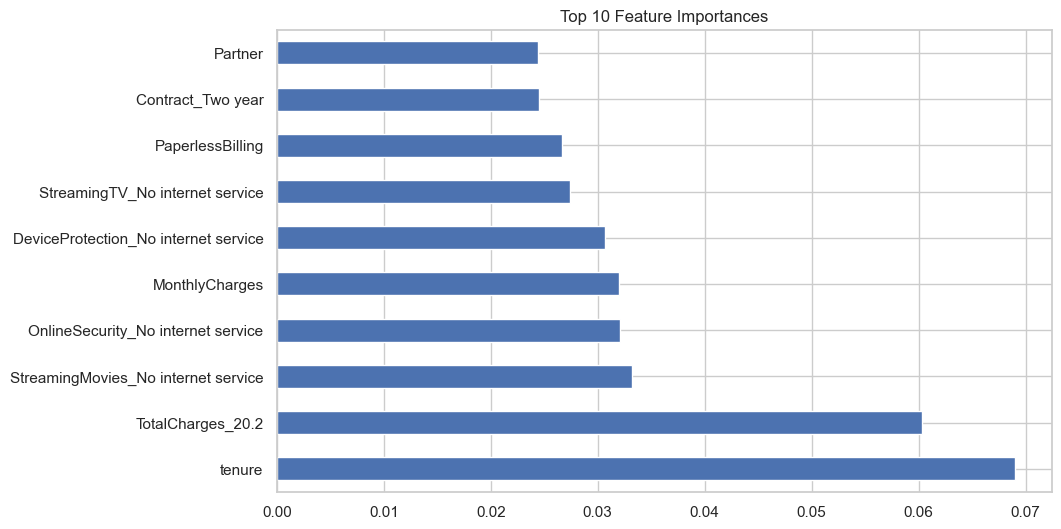

In [11]:
importances = best_model.feature_importances_
feat_importance = pd.Series(importances, index=x.columns).sort_values(ascending=False)
feat_importance[:10].plot(kind='barh')
plt.title("Top 10 Feature Importances")
plt.show()